<h1><center>The Migrants Weep.</center></h1>

## The Missing Migrants Project

In October 2013, the Italian island of Lampedusa saw two shipwrecks that claimed the lives of [368 people $^1$](https://en.wikipedia.org/wiki/2013_Lampedusa_migrant_shipwreck). A further 360 deaths were later reported. The tragedy triggered a response from the International Organisation for Migrants to record incidents in which migrants, refugees and asylum-seekers alike have died in the process of migrating to an international destination.

The [International Organisation for Migrants $^2$](https://missingmigrants.iom.int/)  has recorded over 40,000 deaths among migrants during unsafe migration journeys since 2014, and terms these events as a massive political mis-step in modern times. Naturally, the IOM believes that the data can be analysed to help inform policies to alleviate the pains of the families of those migrants who have gone missing and to put a full stop to future deaths.

This response has taken the shape of the Missing Migrants Project which maintains a database of all reported incidents of deaths and disappearances of people in the process of migrating to an international destination. The aim of the Missing Migrants Project is to "save lives and establish coordinated international efforts on missing migrants."

This notebook serves two purposes. Firstly, it serves to highlight the plight of migrants attempting to reach safety. Secondly, it serves as an exercise in exploratory data analysis. If you would like to run this notebook yourself, and tinker with the dataset, feel free to clone or download my GitHub repo [here](https://github.com/Lockne/Migrant).

## The dataset's design

| Column Name| Description | 
| --- | --- |
| Region|The region where the incident took place.|
| Year| The year the incident took place in.|
|Reported Month| The month in which the incident took place.|
|Total Number of Dead and Missing| We assume that the missing are dead until proven otherwise.|
|Cause of Death| The circumstances of the event that produced the fatal injury.|
|Coordinates| Coordinates for the place where the deaths occured.|
|Migration Route| Name of the migrant route on which the incident occurred.|
| Latitude | Latitude extracted from the coordinate column. |
| Longitude | Longitude extracted from the coordinate column.| 










Each entry in the dataset represents an incident that has claimed the lives of migrants en route to their destination. 

Asking the right questions can lead to the design of better policies and pro-active measures.

Broadly, the contexts that we shall explore are:
 - Which region has seen the most deaths? 
 - What are the primary causes of deaths in that region? 
 - What routes are taken in that region? 
 


Since the data has a lot of missing values and columns unnecessary for our particular analysis, we'll do a bit of data cleaning here.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# pulling and concatenating files into one big dataset
files = os.listdir('./migrantdata/')

year_data = pd.DataFrame()

for file in files:
    df = pd.read_csv('./migrantdata/'+file, thousands=',')
    year_data = pd.concat([year_data, df])

In [3]:
# cleaning the new dataset a bit
year_data = year_data.sort_values(["Year"], ascending = True)
year_data = year_data.rename(columns={'Migrantion route':'Migration route'})
year_data = year_data.drop(columns=['Location of death', 'Information Source', 'Incident Date', 'Minimum Estimated Number of Missing', 'Number of Survivors', 'Number of Females', 'Number of Males', 'Number of Children', 'URL', 'UNSD Geographical Grouping', 'Source Quality', 'Main ID', 'Incident ID'])


In [5]:
# processing the dataset a bit
data = year_data.copy()

data['Latitude'], data['Longitude'] = data['Coordinates'].str.split(', ').str

data.Latitude = data.Latitude.astype(float)
data.Longitude = data.Longitude.astype(float)

locations = data[['Latitude', 'Longitude', 'Total Number of Dead and Missing', 'Region']]
heatmap = folium.Map(location = [locations['Latitude'].mean(), locations['Longitude'].mean()], zoom_start=3)
HeatMap(data=locations.groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),min_opacity=0.6, radius=8, max_zoom=13).add_to(heatmap)

def causeofdeath(d):
    # Health Conditions
    d.loc[d['Cause of Death'].str.contains('Sickness|sickness'), 'Cause of Death'] = 'Health Conditions'
    # Harsh Conditions
    d.loc[d['Cause of Death'].str.contains('Harsh | harsh'), 'Cause of Death'] = 'Harsh Conditions'
    # Unknown
    d.loc[d['Cause of Death'].str.contains('unknown|Unknown'), 'Cause of Death'] = 'Unknown'
    
    # Drowning
    d.loc[d['Cause of Death'].str.contains('Drowning|drowning|Pulmonary|respiratory|lung|bronchial|pneumonia|Pneumonia'), 'Cause of Death'] = 'Drowning'
    
    # Vehicle Accident
    d.loc[d['Cause of Death'].str.contains('train|bus|vehicle|truck|boat|car|road|van|plane|collision'), 'Cause of Death'] = 'Vehicle Accident'
    d.loc[d['Cause of Death'].str.contains('Train|Bus|Vehicle|Truck|Boat|Car|Road|Van|Plane|Collision'), 'Cause of Death'] = 'Vehicle Accident'
    # Murder
    d.loc[d['Cause of Death'].str.contains('murder|stab|shot|violent|blunt force| violence|beat-up|fight|murdered|death'), 'Cause of Death'] = 'Murder and Violence'
    d.loc[d['Cause of Death'].str.contains('Murdered|Stab|Shot|Violent|Blunt|Force|Violence|Beat-up|Fight|Murdered|Death'), 'Cause of Death'] = 'Murder and Violence'
    d.loc[d['Cause of Death'].str.contains('Hanging|Apache|mortar|landmine|Rape|Gassed'), 'Cause of Death'] = 'Murder and Violence'
  
    
# applying the function
causeofdeath(data)

In [113]:
# our processed dataset
data.head(5)

,Region,Year,Reported Month,Number Dead,Total Number of Dead and Missing,Cause of Death,Coordinates,Migration route,Latitude,Longitude
98,North America,2014,June,1.0,1,Unknown,"31.62445, -111.3423",US-Mexico border crossing,31.624450,-111.342300
165,Mediterranean,2014,July,20.0,128,Drowning,"34.4666, 14",Central Mediterranean,34.466600,14.000000
166,North America,2014,July,1.0,1,Murder and Violence,"31.6488, -110.697817",US-Mexico border crossing,31.648800,-110.697817
167,North America,2014,July,1.0,1,Unknown,"32.83222, -112.05419",US-Mexico border crossing,32.832220,-112.054190
168,North America,2014,July,1.0,1,Unknown,"31.949573, -112.871417",US-Mexico border crossing,31.949573,-112.871417


With our dataset prepared, we'll slice our dataset into graphable portions.

In [105]:
# total number of dead and missing in each region
dead_by_region = data.groupby('Region')['Total Number of Dead and Missing'].sum().reset_index()
dead_by_region.sort_values(by=['Total Number of Dead and Missing'], inplace=True, ascending=False)

# cause of death in the Mediterranean and Northern African regions
cause_of_death = data[(data['Region']=='Mediterranean') | (data['Region']=='Northern Africa')].groupby('Cause of Death')['Number Dead'].sum().reset_index()
cause_of_death.sort_values(by=['Number Dead'], inplace=True, ascending=False)

# Number of incidents reported per route
routewise_incident = data[(data['Region']=='Mediterranean') | (data['Region']=='Northern Africa')]['Migration route'].value_counts().reset_index()
routewise_incident.rename(columns={'index':'Migration route', 'Migration route':'Number of Incidents'}, inplace=True)

# Number of dead per route
routewise_deaths = data[(data['Region']=='Mediterranean') | (data['Region']=='Northern Africa')].groupby('Migration route')['Number Dead'].sum().reset_index()
routewise_deaths.sort_values(by=['Number Dead'], inplace=True, ascending=False)

# Number of incidents reported in Western Mediterranean route yearwise
noi_wm_incident = data[(data['Migration route']=='Western Mediterranean')]['Year'].value_counts().reset_index()
noi_wm_incident.rename(columns={'index':'Year', 'Year':'WM'}, inplace=True)
noi_wm_incident.sort_values(by=['Year'], inplace=True, ascending=False)

# Number of incidents reported in Central Mediterranean route yearwise
noi_cm_incident = data[(data['Migration route']=='Central Mediterranean')]['Year'].value_counts().reset_index()
noi_cm_incident.rename(columns={'index':'Year', 'Year':'CM'}, inplace=True)
noi_cm_incident.sort_values(by=['Year'], inplace=True, ascending=False)

# Number of incidents reported in Eastern Mediterranean route yearwise
noi_em_incident = data[(data['Migration route']=='Eastern Mediterranean')]['Year'].value_counts().reset_index()
noi_em_incident.rename(columns={'index':'Year', 'Year':'EM'}, inplace=True)
noi_em_incident.sort_values(by=['Year'], inplace=True, ascending=False)

# Number of incidents reported in Sahara Desert crossing route yearwise
noi_sd_incident = data[(data['Migration route']=='Sahara Desert crossing')]['Year'].value_counts().reset_index()
noi_sd_incident.rename(columns={'index':'Year', 'Year':'SD'}, inplace=True)
noi_sd_incident.sort_values(by=['Year'], inplace=True, ascending=False)

## The Mediterranean region has claimed many migrants

The nation of Eritrea, near the Horn of Africa, is host to a dying economy, overflowing prisons, and a mad dictator. Eritreans live in conditions of marginal rainfall and war. Consider the story of [Michael and Niyat $^3$](https://www.rgs.org/schools/teaching-resources/mediterranean-migration-crisis/). Michael slaved in Eritrea for 14 long years until one day he decided to give it all up. As part of their escape from Eritrea, Michael and Niyat paid smugglers to take them to Libya across the Sahara Desert. They were eventually held captive, beaten and pressured to raise money for additional payments for the final journey across the Mediterranean Sea. Ultimately, they were rescued by an Italian ship after spending five hours at sea.

Michael and Niyat said that what pushed them to take the gruelling journey was a search for safety and a better life for themselves and their baby.

[Blessing $^4$](https://www.migrantsofthemed.com/meet-blessing) left Nigeria on a ten month journey to reach Italy. Blessing saw 15 passengers die as she and 80 others journeyed across the Sahara in the back of a pickup truck. She reached Libya and stayed at a compound with no facilities for sleep, no toilets, no sunlight and no windows. Blessing was raped and tortured by Libyan traffickers, and was also shot in the leg when a brigand of traffickers fired at them without reason. She crossed the Mediterranean sea along with 130 others and reached safety at Crotone.

The Mediterranean region has claimed many lives, a large number of whom are still missing to this day. 

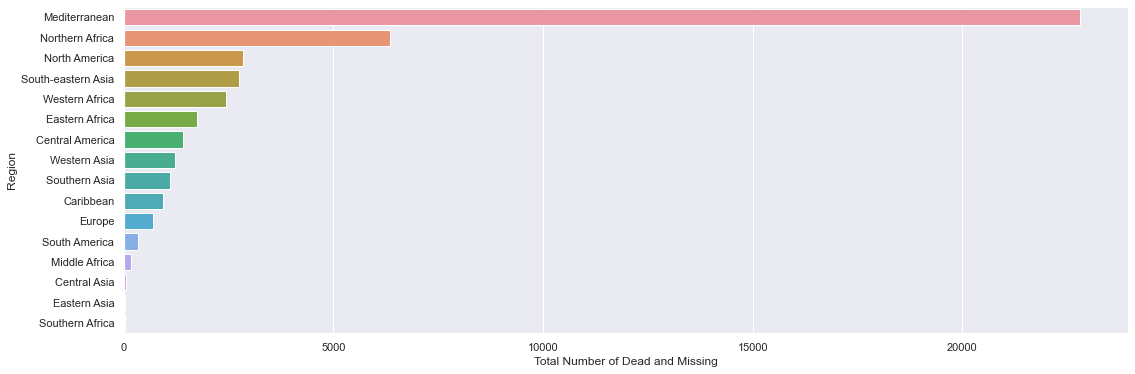

In [106]:
sns.barplot(data=dead_by_region, y='Region', x='Total Number of Dead and Missing')
sns.set(rc={'figure.figsize':(18, 6)})

<h5><center>Dead and missing per region</center></h5>

In [ ]:
heatmap

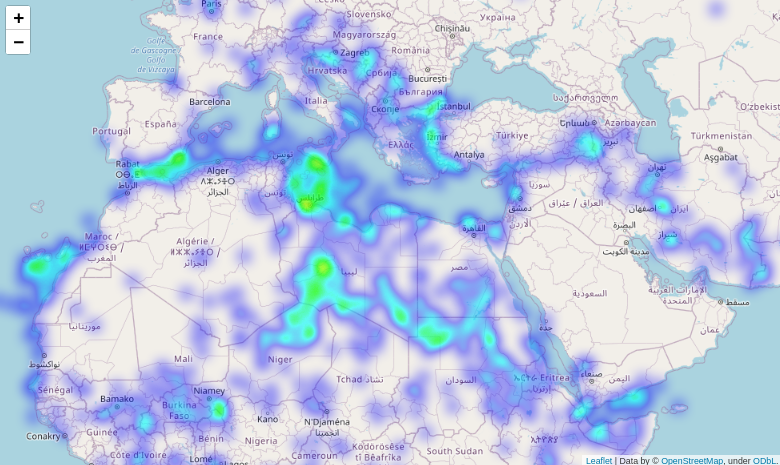

<h5><center>Heatmap of incidents in the Mediterranean and Northern Africa</center></h5>

## The migrants drown. They are murdered. They starve and they thirst.

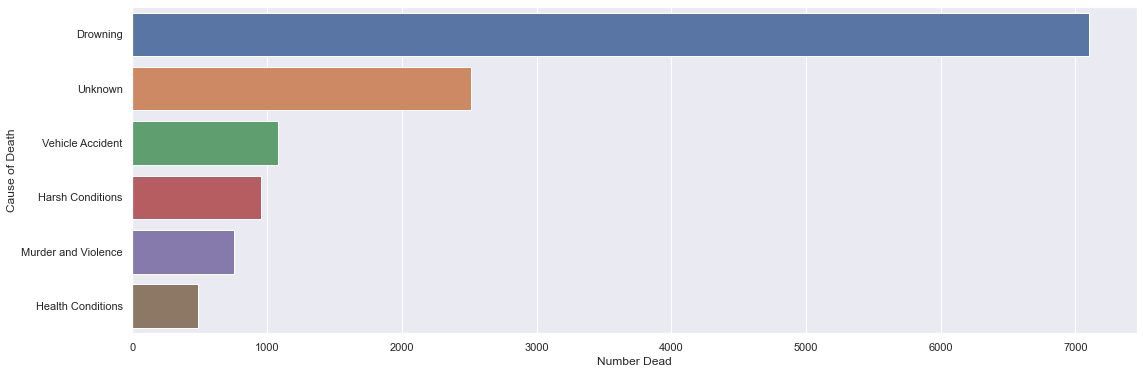

In [107]:
sns.barplot(data=cause_of_death, x='Number Dead', y='Cause of Death')
sns.set(rc={'figure.figsize':(15, 5)})

Through Nigeria, Niger and Libya, [Dante $^5$](https://www.migrantsofthemed.com/meet-blessing) travelled to find safety in Lampedusa, Italy. He found himself trapped in Libya and lived in a container truck for two months with just one set of clothes, a mattress, a rug, and a piece of bread for daily sustenance. He escaped Libya in a rubber boat with a hundred other migrants, and was rescued over the Mediterranean sea on his way to Lampedusa. 

Ghanaians migrate by sea in search of jobs. Nigerians and the people of Chad and Ivory Coast migrate to flee conflict. Disease too forces migrations. For these migrants, the possibility of death is very real and has to be borne in their search for safety and refuge. 

Scores of human beings have migrated from the northern coasts of Africa and Turkey for safety and refuge in Europe.
Since 2014, the Mediterranean Sea has claimed the lives of more than 20000 migrants attempting to cross it. The figures also account for only the minimum number of deaths and missing cases of migrants attempting to cross the Mediterranean sea. Many ships have disappeared without a trace, and bodies of dead migrants do wash up on Libyan shores from time to time.

Eyewitness reports claim that Greek authorities purposely abandon migrants in the middle of the sea. This comes in the wake of increased claims from migrants and advocates that Greek authorities push back people migrating to Greece through the Mediterranean.

Others lose their lives in vehicular accidents, are murdered, or find themselves dying from hunger, thirst and exposure. For many, their cause of death is hard to determine.







## Peril meets the migrants every step of the way.

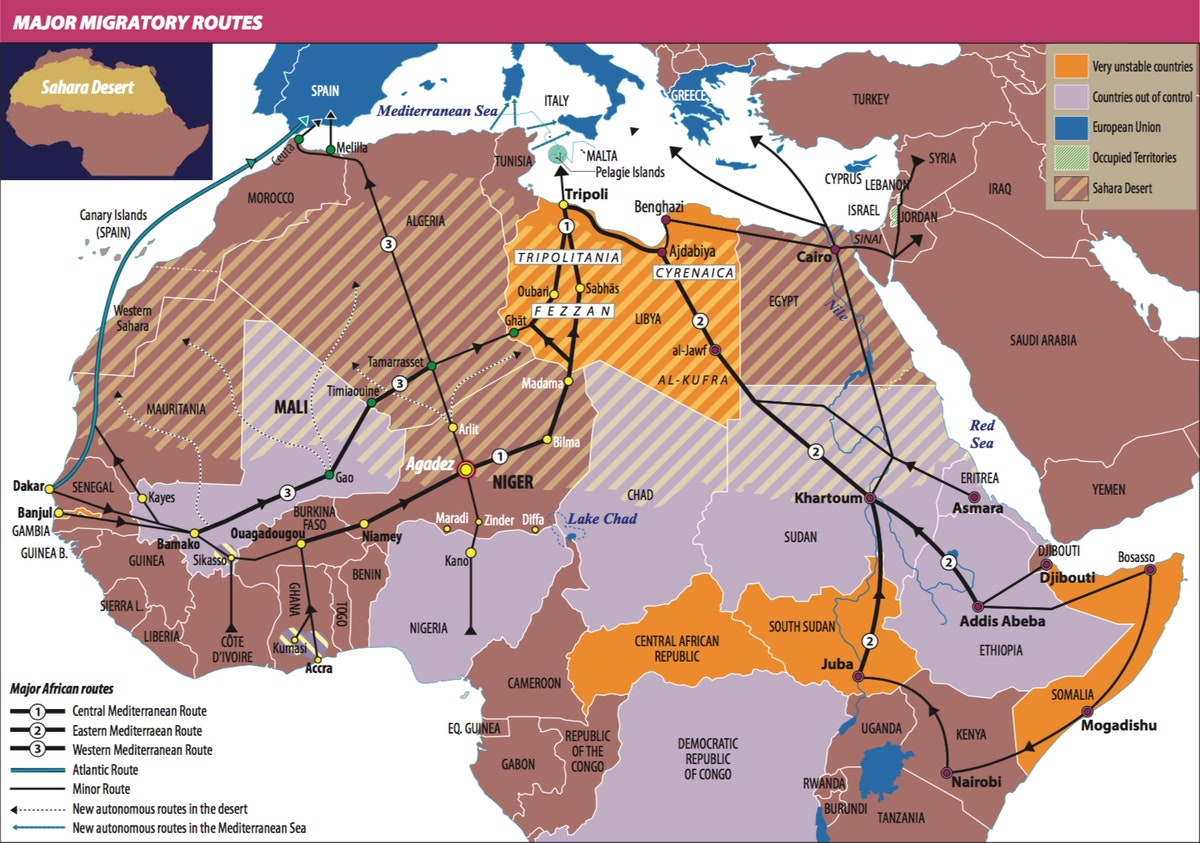

<h5><center>Major migratory routes in Northern Africa and the Mediterranean$^1$</center></h5>

[Alex $^6$](https://www.migrantsofthemed.com/meet-blessing) journeyed through Gambia, Senegal, Mali, Burkina Faso, Niger and Libya. He crossed the Sahara desert with more than 25 others. Their journey involved evading capture and braving exhaustion, sickness and dehydration. 

Luckily, all of them survived. Alex finally managed to cross the Mediterranean Sea in a rubber boat with 161 other people.

[Sajed Nafez $^7$](https://www.middleeasteye.net/features/story-missing-mediterranean-migrant) wasn't as lucky. A budding film scholar, Sajed made an escape from Gaza. He reached Alexandria in Egypt and boarded a ship for Europe. Six days later, his family received the news that Sajed and 500 other migrants drowned at sea after his ship was rammed and sunk on purpose by traffickers.

It is reported that a greater number of African migrants attempting to crossover to Europe may be dying and vanishing without a trace in the Sahara desert than in the Mediterranean sea. A report by 4mi suggests that traversing the Mediterranean is less risky than crossing the Sahara. Unfortunately, reliable data on land routes is hard to find. It is estimated that for every migrant death in the Mediterranean, there are at least two in the Sahara. 

Often times migrants are captured and sent to prisons. They are never heard from again and it can be assumed that they live tortured lives. As an example, Libyan laws deem anyone arriving without a permit as an illegal migrant thereby granting the Libyan authorities power to jail them.


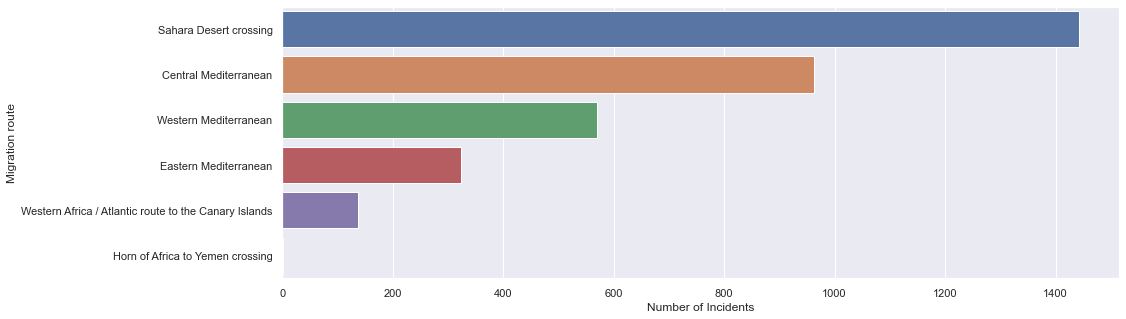

In [108]:
sns.barplot(data=routewise_incident, x='Number of Incidents', y='Migration route')
sns.set(rc={'figure.figsize':(15, 5)})

<h5><center>Number of incidents reported per migration route</center></h5>

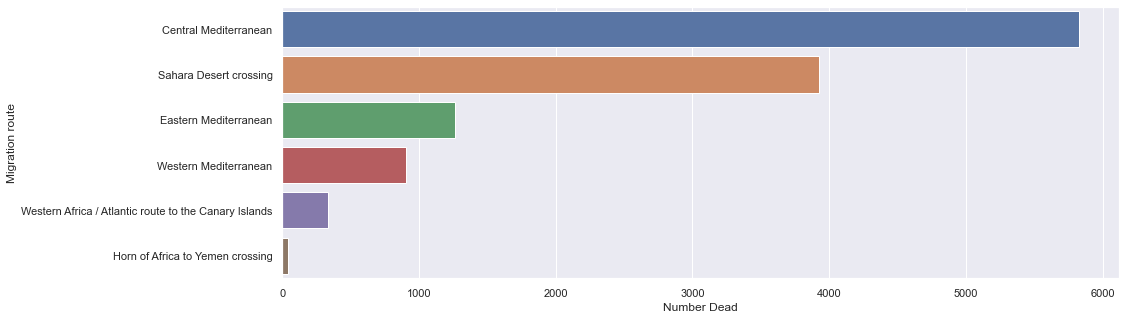

In [109]:
sns.barplot(data=routewise_deaths, x='Number Dead', y='Migration route')
sns.set(rc={'figure.figsize':(15, 5)})

<h5><center>Number of confirmed dead per migration route</center></h5>

## Politics does little to assuage migrants' fears.

[Foday $^9$](https://www.migrantsofthemed.com/meet-foday) and his brother were kidnapped and tortured at Sabha, Libya. They escaped and ran through the night to save their lives. He arrived in Tripoli and was smuggled to the coastline to find 300 other migrants waiting to leave the shore, a scene reminiscent of the movie Dunkirk. Foday crossed the Mediterranean with 115 people, and found safety at Sicily.



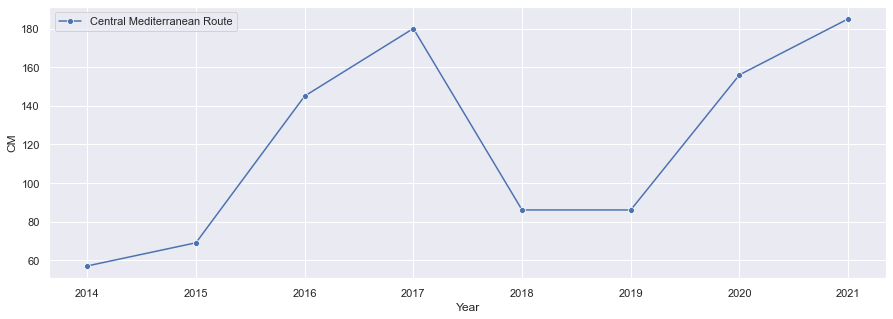

In [110]:
sns.lineplot(data=noi_cm_incident, x='Year', y='CM', marker='o')
plt.legend(['Central Mediterranean Route'])

<h5><center>Number of incidents reported per year in the Central Mediterranean route</center></h5>

Libya is the main embarkation country for the Central Mediterranean route. In the EU summit of 2017, a [memorandum $^{10}$](https://www.asgi.it/wp-content/uploads/2017/02/ITALY-LIBYA-MEMORANDUM-02.02.2017.pdf) was drawn up between Italy and Libya. This memorandum offers funds to improve conditions in migrant detention centers, increased support to the Libyan Navy and Coast Guard to rescue migrant boats in Libyan waters, and restarts the 2008 Friendship Treaty between Italy and Libya which also provides systems for migration containment to the Libyan government.

The years 2017 to 2019 saw a sharp decline in incidents of migrants going missing or dying in the Central Mediterranean route. It is possible that this decrease is attributable to measures taken by EU member states to restrict mixed migrations across the Mediterranean Sea.

Essentially, this deal allows the EU to close off the Central Mediterranean route and reduce migrant flows by giving the Libyan authorities more power to pushback on the migrants attempting to cross over to Italy.

While the memorandum does allow more migrant boats to be rescued at sea, the memorandum does not make any allowance for the fact that Africans arriving in Libya are harassed, raped, thrust into slavery, detained and killed. The EU does claim that the memorandum is aligned with its goals to demolish the business of smugglers.

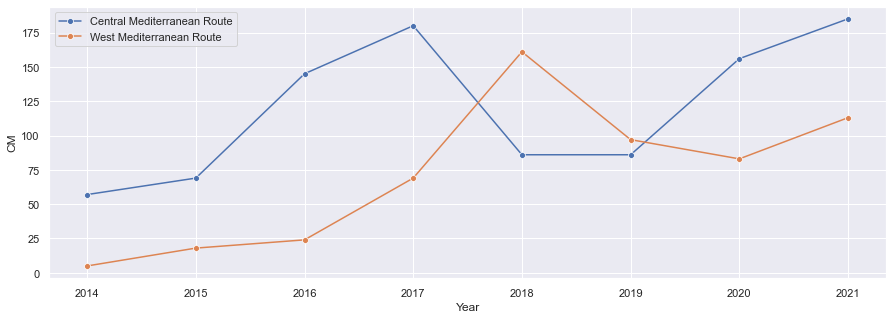

In [111]:
sns.lineplot(data=noi_cm_incident, x='Year', y='CM', marker='o')
sns.lineplot(data=noi_wm_incident, x='Year', y='WM', marker='o')
plt.legend(['Central Mediterranean Route', 'West Mediterranean Route'])

<h5><center>Number of incidents reported per year across the Central Mediterranean and West Mediterranean routes</center></h5>

Interestingly, there is a noticeable spike in incidents of missing migrants in the West Mediterranean route corresponding with the decline of of incidents on the Central Mediterranean route in the years 2017 to 2019. Is this indicative of a shift from the Central Mediterranean route to the Western Mediterranean route? One [article $^{11}$](https://mixedmigration.org/articles/shift-to-the-western-mediterranean-migration-route/) suggests that this shift can only be confirmed if one closely analyses the main nationalities using the Central Mediterranean route and proves that there is an increase in the same group of nationalities along the Western Mediterranean route.

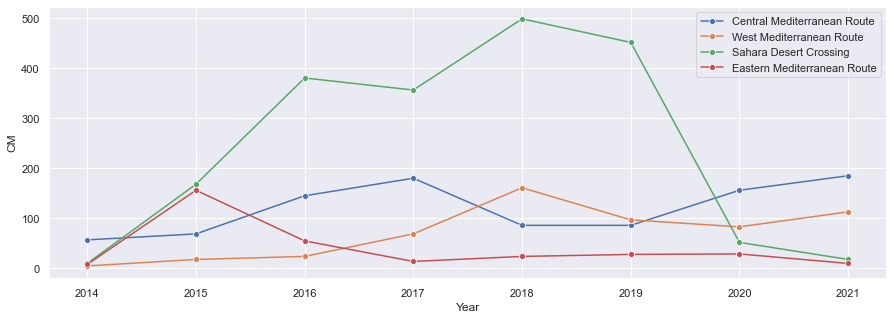

In [112]:
sns.lineplot(data=noi_cm_incident, x='Year', y='CM', marker='o')
sns.lineplot(data=noi_wm_incident, x='Year', y='WM', marker='o')
sns.lineplot(data=noi_sd_incident, x='Year', y='SD', marker='o')
sns.lineplot(data=noi_em_incident, x='Year', y='EM', marker='o')
plt.legend(['Central Mediterranean Route', 'West Mediterranean Route', 'Sahara Desert Crossing', 'Eastern Mediterranean Route'])

<h5><center>Number of incidents reported per year across four major migration routes</center></h5>

# Sources


[1] : https://en.wikipedia.org/wiki/2013_Lampedusa_migrant_shipwreck

[2] : https://missingmigrants.iom.int/

[3] : https://www.rgs.org/schools/teaching-resources/mediterranean-migration-crisis/

[4] : https://www.migrantsofthemed.com/meet-blessing

[5] : https://www.migrantsofthemed.com/meet-dante

[6] : https://www.migrantsofthemed.com/meet-alex

[7] : https://www.middleeasteye.net/features/story-missing-mediterranean-migrant

[9] : https://www.migrantsofthemed.com/meet-foday

[10] : https://www.asgi.it/wp-content/uploads/2017/02/ITALY-LIBYA-MEMORANDUM-02.02.2017.pdf

[11] : https://mixedmigration.org/articles/shift-to-the-western-mediterranean-migration-route/
